In [1]:
import pandas as pd
import numpy as np
import warnings
warnings.filterwarnings('ignore')
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
import matplotlib.font_manager as fm
plt.rc('font', family=fm.FontProperties(fname="c:/Windows/Fonts/malgun.ttf").get_name())
from tqdm import tqdm
import re

In [2]:
# HTS
t18 = pd.read_csv('data/01_제공데이터/2021 빅콘테스트_데이터분석분야_챔피언리그_스포츠테크_HTS_2018.csv', encoding='cp949')
t19 = pd.read_csv('data/01_제공데이터/2021 빅콘테스트_데이터분석분야_챔피언리그_스포츠테크_HTS_2019.csv', encoding='cp949')
t20 = pd.read_csv('data/01_제공데이터/2021 빅콘테스트_데이터분석분야_챔피언리그_스포츠테크_HTS_2020.csv', encoding='cp949')
t21 = pd.read_csv('data/01_제공데이터/2021 빅콘테스트_데이터분석분야_챔피언리그_스포츠테크_HTS_2021.csv', encoding='cp949')

# 경기일정
game = pd.read_csv('data/01_제공데이터/2021 빅콘테스트_데이터분석분야_챔피언리그_스포츠테크_경기일정_2021.csv', encoding='cp949')

# 선수
p18 = pd.read_csv('data/01_제공데이터/2021 빅콘테스트_데이터분석분야_챔피언리그_스포츠테크_선수_2018.csv', encoding='cp949')
p19 = pd.read_csv('data/01_제공데이터/2021 빅콘테스트_데이터분석분야_챔피언리그_스포츠테크_선수_2019.csv', encoding='cp949')
p20 = pd.read_csv('data/01_제공데이터/2021 빅콘테스트_데이터분석분야_챔피언리그_스포츠테크_선수_2020.csv', encoding='cp949')
p21 = pd.read_csv('data/01_제공데이터/2021 빅콘테스트_데이터분석분야_챔피언리그_스포츠테크_선수_2021.csv', encoding='cp949')

# 타자 기본
h18 = pd.read_csv('data/01_제공데이터/2021 빅콘테스트_데이터분석분야_챔피언리그_스포츠테크_타자 기본_2018.csv', encoding='cp949')
h19 = pd.read_csv('data/01_제공데이터/2021 빅콘테스트_데이터분석분야_챔피언리그_스포츠테크_타자 기본_2019.csv', encoding='cp949')
h20 = pd.read_csv('data/01_제공데이터/2021 빅콘테스트_데이터분석분야_챔피언리그_스포츠테크_타자 기본_2020.csv', encoding='cp949')
h21 = pd.read_csv('data/01_제공데이터/2021 빅콘테스트_데이터분석분야_챔피언리그_스포츠테크_타자 기본_2021.csv', encoding='cp949')

# 팀
team = pd.read_csv('data/01_제공데이터/2021 빅콘테스트_데이터분석분야_챔피언리그_스포츠테크_팀.csv', encoding='cp949')

# 서브미션
submission = pd.read_excel('data/02_평가데이터/2021 빅콘테스트_데이터분석분야_챔피언리그_스포츠테크_평가데이터.xlsx')

In [3]:
hts = pd.concat([t18, t19, t20, t21], axis=0).reset_index(drop=True)
player = pd.concat([p18, p19, p20, p21], axis=0).reset_index(drop=True)
hit = pd.concat([h18, h19, h20, h21], axis=0).reset_index(drop=True)

In [4]:
hts.columns = ['연도', '경기코드', '타구코드', '선수코드', '팀코드', '이닝', '타구속도', '발사각도', '타격결과', '상대투수투구구속', '해당구장']
player.columns = ['연도', '선수코드', '선수명', '팀코드', '포지션', '나이', '연봉']
hit.columns = ['연도', '선수코드', '경기', '타석', '타수', '타율', '안타', '홈런', '루타', '장타율', '희생플라이', '볼넷', '삼진', '고의4구', '사구', '병살타']

## 기본 전처리

In [75]:
player

,연도,선수코드,선수명,팀코드,포지션,나이,연봉
0,2018,60100,백창수,HH,외,30,5000
5,2018,60184,김창혁,HH,포,27,2700
8,2018,60288,김응민,SS,포,26,3000
12,2018,60343,이해창,KT,포,31,7100
14,2018,60456,백상원,SS,내,30,6000
...,...,...,...,...,...,...,...
2626,2021,79365,박동원,WO,포,31,23000
2627,2021,79402,김상수,SS,내,31,25000
2629,2021,79456,이지영,WO,포,35,30000
2631,2021,79608,안치홍,LT,내,31,29000


In [5]:
# 연봉 통일
player = player[-player['연봉'].isnull()]
player['money2'] = player['연봉'].str.replace('[가-힣]','').astype('int64')
player.loc[player['연봉'].str.endswith('달러'), 'money2'] = player.loc[player['연봉'].str.endswith('달러'), 'money2'].apply(lambda x : x * 0.12).astype('int64')
player['연봉'] = player['money2']
player.drop('money2', axis=1, inplace=True)

data = {'연도': 2020, '선수코드': 50802, '선수명':'화이트', '팀코드':'SK', '포지션':'내', '나이': 31, '연봉': 16000}
player = player.append(data, ignore_index=True)
hts.shape, player.shape, hit.shape

((120745, 11), (2635, 7), (1098, 16))

In [6]:
hts['상대팀코드'] = hts.경기코드.str[-5:-1]
for i in tqdm(range(hts.shape[0])):
    hts['상대팀코드'].iloc[i] = hts.iloc[i].상대팀코드.replace(hts.iloc[i].팀코드, '')

100%|█████████████████████████████████████████████████████████████████████████| 120745/120745 [03:55<00:00, 512.32it/s]


In [7]:
hts['날짜'] = '20' + hts.타구코드.str.split('_').str[0] + hts.타구코드.str.split('_').str[1]
hts['날짜'] = pd.to_datetime(hts.날짜)
hts['년'] = hts.날짜.dt.year
hts['월'] = hts.날짜.dt.month
hts['일'] = hts.날짜.dt.day
hts['시간'] = hts.날짜.dt.hour
hts['요일'] = hts.날짜.dt.dayofweek
hts['날짜'] = hts['날짜'].astype(str)

In [8]:
# 출루율 = (안타 + 볼넷 + 몸에 맞는 볼) / (타수 + 볼넷 + 몸에 맞는 볼 + 희생플라이)
# on base percentage
hit['출루율'] = (hit['안타'] + hit['볼넷'] + hit['사구']) / (hit['타수'] + hit['볼넷'] + hit['사구'] + hit['희생플라이'])
hit['OPS'] = hit['장타율'] + hit['출루율']
team.columns = ['연도', '팀코드', '팀이름']
hit = hit.merge(player, on=['연도', '선수코드'], how='left')
hit = hit.merge(team, on=['연도', '팀코드'], how='left')

In [76]:
hit_log = pd.read_csv('data/hit_log.csv', index_col=0) # 타자 당 날짜별 기록
hit_log['날짜'] = hit_log['연도'].astype(int).astype(str) + '-' + hit_log['ss'].astype(str)
hit_log['상대팀코드'] = hit_log['상대'].apply(lambda x : 'KT' if ('KT' in x)
                                       else 'LG' if ('LG' in x)
                                       else 'NC' if ('NC' in x)
                                       else 'HT' if ('KIA' in x)
                                       else 'SK' if (('SK' in x) or ('SSG' in x))
                                       else 'SS' if ('삼성' in x)
                                       else 'LT' if ('롯데' in x)
                                       else 'OB' if ('두산' in x)
                                       else 'HH' if ('한화' in x)
                                       else 'WO')
hit_log['스코어'] = hit_log['결과'].apply(lambda x : x.split(' ')[1]) 
hit_log['결과'] = hit_log['결과'].apply(lambda x : x.split(' ')[0])

# avLI - 얼마나 중요한 상황에 등판했는가(평균)
# RE24 - 상황대비 기대득점
# WPA - 승리 확률 기여도(두 상황 간의 기대승률 차이)
hit_log['WPA/avLI'] = (hit_log['WPA'] / (hit_log['avLl']+0.0001)).fillna(0)

In [77]:
hit_log = hit_log.query('날짜 <= "2021-07-11"')

In [78]:
hts = hts.merge(player.drop('팀코드', axis=1), on=['선수코드', '연도'], how='left')
hts['날짜'] = hts['날짜'].str[:10]
hit_log['날짜'] = pd.to_datetime(hit_log.날짜)
hit_log['년'] = hit_log.날짜.dt.year
hit_log['월'] = hit_log.날짜.dt.month
hit_log['일'] = hit_log.날짜.dt.day
hit_log['요일'] = hit_log.날짜.dt.dayofweek
hit_log['날짜'] = hit_log['날짜'].astype(str)

#hit_log.drop('연도', axis=1, inplace=True)

In [79]:
hts1 = hts[['상대팀코드', '팀코드', '날짜']].drop_duplicates()
hit_log = hit_log.merge(hts1, on=['날짜', '상대팀코드'], how='left')

player = player.query('포지션 != "투"')
hit_log = hit_log.merge(player, on=['연도', '팀코드', '선수명'], how='left')

In [80]:
hit_log = hit_log.fillna(method='ffill')

In [81]:
hit_log['일타율'] = ((hit_log['안타'] + hit_log['2타'] + hit_log['3타'] + hit_log['홈런']) / hit_log['타수']).fillna(0)

In [82]:
hit_log['WPA'].describe()

count    63748.000000
mean         0.003403
std          0.097643
min         -0.719000
25%         -0.046000
50%          0.000000
75%          0.035000
max          1.246000
Name: WPA, dtype: float64

In [83]:
hit_log

,ss,상대,결과,타순,P,선발,타수,득점,안타,2타,...,년,월,일,요일,팀코드,선수코드,포지션,나이,연봉,일타율
0,07-19,@KT,L,8,PH,0,1,0,1,0,...,2018,7,19,3,HH,60184.0,포,27.0,2700.0,1.000000
1,07-22,@삼성,L,8,C,1,3,0,0,0,...,2018,7,22,6,HH,60184.0,포,27.0,2700.0,0.000000
2,09-06,@KT,W,5,PR,0,2,1,1,1,...,2018,9,6,3,HH,60184.0,포,27.0,2700.0,1.000000
3,09-07,@KT,L,6,PH,0,1,0,0,0,...,2018,9,7,4,HH,60184.0,포,27.0,2700.0,0.000000
4,09-09,@LG,L,8,PH,0,2,0,0,0,...,2018,9,9,6,HH,60184.0,포,27.0,2700.0,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
63743,07-04,한화,W,6,1B,1,3,1,1,0,...,2021,7,4,6,LG,69102.0,내,20.0,3000.0,0.333333
63744,07-05,한화,W,2,1B,1,4,1,2,0,...,2021,7,5,0,LG,69102.0,내,20.0,3000.0,0.500000
63745,07-02,@KT,L,8,1B,1,3,0,1,0,...,2021,7,2,4,WO,69366.0,내,21.0,3000.0,0.333333
63746,07-04,@KT,L,8,1B,1,2,0,0,0,...,2021,7,4,6,WO,69366.0,내,21.0,3000.0,0.000000


## 가정 - 피처 관련
- 개인역량(배럴타구 / 기간성적)
- 팀역량(팀상성)
- 컨디션(이동거리 / 아시안게임(2018), 올림픽(2021) / 경기시간대 / 지명타자출전 / 몇경기 연속 출장했는지)
- 날씨

### 개인역량
#### 배럴타구 : 타구 속도와 발사각도의 조합상 평균적으로 타율 .500, 장타율 1.500이상을 생산하는 타구들로 정의
* 기존 MLB의 배럴 기준으로는 타구속도가 안나옴(MLB와 KBO의 평균 타구 속도 차이)
* 기대 성적으로 접근하는 방법 사용 : 한국에서 안타 확률 50%이상 장타율 1.500 이상을 기록할 수 있는 타구 스피드와 발사각 구간
* 타구 속도 시속 155-160km, 발사각 22.5-35.0도 / 타구 속도 시속 160-165km, 발사각 20.0-37.5도 / 타구 속도 시속 165km 이상, 발사각 17.5-40.0도
* (출처 : http://www.spotvnews.co.kr/?mod=news&act=articleView&idxno=199017)

In [16]:
hts['타구속도'].describe()

count    120745.000000
mean        133.732175
std          21.337877
min           9.880000
25%         121.680000
50%         137.700000
75%         149.480000
max         210.130000
Name: 타구속도, dtype: float64

In [17]:
# BARREL_KBO식
hts['배럴'] = 0

def BARREL_KBO(x):
    for i in range(hts.shape[0]):       
        if (x['타구속도'][i] >= 155) and (x['타구속도'][i] < 160):
            if (x['발사각도'][i] >= 22.5) and (x['발사각도'][i] <= 35.0):
                hts['배럴'][i] = 1
            else:
                hts['배럴'][i] = 0
        elif (x['타구속도'][i] >= 160) and (x['타구속도'][i] < 165):
            if (x['발사각도'][i] >= 20.0) and (x['발사각도'][i] <= 37.5):
                hts['배럴'][i] = 1
            else:
                hts['배럴'][i] = 0
        elif (x['타구속도'][i] >= 165):
            if (x['발사각도'][i] >= 17.5) and (x['발사각도'][i] <= 40):
                hts['배럴'][i] = 1
            else:
                hts['배럴'][i] = 0
                
BARREL_KBO(hts)

In [18]:
hts['배럴'].value_counts() / hts['배럴'].count()   # 약 2%의 타구

0    0.977639
1    0.022361
Name: 배럴, dtype: float64

In [19]:
hts.query('배럴 == 1')['타격결과'].value_counts()
# 타율 : 0.8921
# 장타율 : 3.3246

홈런       2066
플라이       289
2루타       279
3루타        32
1루타        22
희생플라이      11
직선타         1
Name: 타격결과, dtype: int64

In [20]:
### 출루 시 발사각과 타구속도
hts['타구출루'] = hts['타격결과'].apply(lambda x : 1 if x in ['1루타', '2루타', '3루타', '홈런'] else 0)
hts.groupby(['선수코드', '타구출루'])['발사각도'].describe().unstack()

count              mean                   std              min        \
타구출루       0      1          0          1          0          1     0     1   
선수코드                                                                          
50054   40.0   15.0  20.702500   8.373333  25.730193  14.820568 -19.5 -15.2   
50066   11.0    6.0  17.245455  12.366667  27.958697  11.649149 -13.1  -0.6   
50150   19.0   11.0  24.436842  17.790909  28.726279  14.329302 -23.7  -1.6   
50165  249.0  158.0  27.530522  18.539873  26.520499  13.547590 -26.9 -13.5   
50167    5.0    1.0  43.660000  11.700000  22.305224        NaN  25.9  11.7   
...      ...    ...        ...        ...        ...        ...   ...   ...   
79530   21.0   10.0  22.552381   8.870000  31.991790  13.287258 -19.6 -14.1   
79608  748.0  442.0  21.900936  11.045701  29.536770  12.446251 -62.3 -24.2   
79705   84.0   45.0  26.851190  15.755556  29.933700  14.083542 -36.6  -9.0   
99606   68.0   51.0  15.025000  10.643137  28.358654  11.563153 -54.5 -14.0   
99810  138.0   80.0  15.392029   8.561250  29.380330  14.066861 -43.7 -29.6   

          25%            50%            75%           max        
타구출루        0       1      0      1       0       1     0     1  
선수코드                                                             
50054  -0.825   5.600  21.65   7.10  34.350   9.700  83.7  53.4  
50066  -5.900   6.150   8.40   9.80  40.500  15.550  59.5  32.8  
50150   1.250  10.400  23.70  19.70  42.050  21.200  74.3  48.8  
50165   3.800   9.425  27.60  17.45  47.000  27.350  83.6  59.1  
50167  29.000  11.700  31.10  11.70  54.100  11.700  78.2  11.7  
...       ...     ...    ...    ...     ...     ...   ...   ...  
79530  -6.100   8.525   9.80  10.00  48.400  12.225  86.6  36.4  
79608  -3.800   3.700  21.20  10.40  44.125  19.275  87.4  54.1  
79705   0.275   5.400  33.80  14.80  51.975  27.100  85.1  42.6  
99606  -5.975   2.750   6.05  11.20  37.250  18.900  84.5  38.6  
99810  -7.650   1.000  12.40   9.55  36.625  16.300  85.9  45.9  

[437 rows x 16 columns]

#### 성적(요일별, 시간별, 포지션별)

In [21]:
# 요일별 성적 -> 더미 변수로
hit_log.groupby(['선수코드', '요일'])['WPA/avLI'].mean().unstack().fillna(0)

요일,0,1,2,3,4,5,6
선수코드,,,,,,,
50054.0,-0.024969,0.007834,-0.004292,0.002195,-0.007006,-0.002119,-0.026527
50066.0,0.000000,-0.025010,-0.021129,-0.033463,-0.026666,-0.001796,0.045775
50150.0,-0.009999,0.016815,-0.016895,0.006347,0.001340,-0.036055,0.022990
50165.0,-0.040542,0.011947,0.070973,0.046289,0.013585,0.016785,-0.015859
50167.0,0.000000,-0.008124,-0.029063,0.043964,-0.034780,-0.020008,-0.015832
...,...,...,...,...,...,...,...
79530.0,0.000000,0.002075,-0.039869,-0.040052,-0.015678,-0.012725,-0.039286
79608.0,0.208671,0.026351,0.006486,0.008711,0.033621,0.010632,0.021123
79705.0,-0.082768,0.021803,0.009799,-0.012198,-0.006141,0.015308,-0.005669


In [22]:
hit_log.groupby(['선수코드', '요일'])['일타율'].mean().unstack().fillna(0)

요일,0,1,2,3,4,5,6
선수코드,,,,,,,
50054.0,0.000000,0.096154,0.243590,0.093750,0.027778,0.093750,0.108974
50066.0,0.000000,0.166667,0.000000,0.000000,0.050000,0.333333,0.687500
50150.0,0.000000,0.166667,0.625000,0.388889,0.080000,0.000000,0.300000
50165.0,0.208333,0.393333,0.489744,0.409140,0.366667,0.300617,0.336420
50167.0,0.000000,1.000000,0.000000,0.250000,0.000000,0.000000,0.000000
...,...,...,...,...,...,...,...
79530.0,0.000000,0.111111,0.062500,0.333333,0.500000,0.166667,0.000000
79608.0,0.625000,0.474648,0.362381,0.336667,0.423810,0.345833,0.428974
79705.0,0.000000,0.250000,0.250694,0.100000,0.214912,0.458333,0.083333


In [23]:
hit_log.groupby(['선수코드', 'P'])['WPA/avLI'].mean().unstack().fillna(0)

P,1B,2B,3B,C,CF,DH,LF,P,PH,PR,RF,SS
선수코드,,,,,,,,,,,,
50054.0,-0.016646,-0.013129,0.008192,0.000000,0.0,-0.023516,0.0,0.0,-0.024083,0.004706,0.000000,-0.027510
50066.0,0.000000,0.000000,0.000000,-0.007989,0.0,0.000000,0.0,0.0,-0.062672,0.000000,0.000000,0.000000
50150.0,0.034983,-0.024999,-0.002442,0.000000,0.0,0.000000,0.0,0.0,0.039984,0.000497,0.000000,-0.017836
50165.0,0.021904,0.000000,0.000000,0.000000,0.0,0.028866,0.0,0.0,0.000241,0.000000,0.000000,0.000000
50167.0,0.009290,0.000000,0.000000,0.000000,0.0,-0.015832,0.0,0.0,-0.031835,-0.002031,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...
79530.0,-0.018474,-0.027833,-0.037582,0.000000,0.0,0.000000,0.0,0.0,-0.029135,0.019900,0.000000,0.000000
79608.0,-0.001312,0.021871,0.000000,0.000000,0.0,0.002043,0.0,0.0,-0.000714,0.000000,0.000000,0.000000
79705.0,-0.009484,0.000000,0.011693,0.000000,0.0,0.000000,0.0,0.0,0.023016,0.059980,0.000000,0.000000


In [24]:
hit_log.groupby(['선수코드', 'P'])['일타율'].mean().unstack().fillna(0)

P,1B,2B,3B,C,CF,DH,LF,P,PH,PR,RF,SS
선수코드,,,,,,,,,,,,
50054.0,0.000000,0.102151,0.149123,0.000000,0.0,0.666667,0.0,0.0,0.031250,0.057692,0.00000,0.125
50066.0,0.000000,0.000000,0.000000,0.229167,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.00000,0.000
50150.0,1.000000,0.000000,0.384848,0.000000,0.0,0.000000,0.0,0.0,0.250000,0.166667,0.00000,0.000
50165.0,0.373543,0.000000,0.000000,0.000000,0.0,0.374667,0.0,0.0,0.666667,0.000000,0.00000,0.000
50167.0,0.166667,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.250000,0.00000,0.000
...,...,...,...,...,...,...,...,...,...,...,...,...
79530.0,0.190476,0.148148,0.135417,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.600000,0.00000,0.000
79608.0,0.229412,0.418021,0.000000,0.000000,0.0,0.313542,0.0,0.0,0.260000,0.000000,0.00000,0.000
79705.0,0.123239,0.000000,0.296259,0.000000,0.0,0.000000,0.0,0.0,0.479167,0.500000,0.00000,0.000


In [25]:
hts.groupby(['선수코드', '시간'])['배럴'].mean().unstack().fillna(0)

시간,13,14,15,16,17,18,19,20,21,22,23
선수코드,,,,,,,,,,,
50054,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.00,0.0
50066,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.00,0.0
50150,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.00,0.0
50165,0.0,0.173913,0.050000,0.1,0.111111,0.106667,0.126316,0.100000,0.113208,0.25,0.0
50167,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.00,0.0
...,...,...,...,...,...,...,...,...,...,...,...
79530,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.00,0.0
79608,0.0,0.000000,0.000000,0.0,0.012500,0.011905,0.010101,0.008163,0.006250,0.00,0.0
79705,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.00,0.0


In [26]:
hts.groupby(['선수코드', '시간'])['타구출루'].mean().unstack().fillna(0)

시간,13,14,15,16,17,18,19,20,21,22,23
선수코드,,,,,,,,,,,
50054,0.0,1.000000,0.250000,0.000000,0.000000,0.000000,0.500000,0.363636,0.125000,0.000000,0.0
50066,0.0,0.000000,1.000000,0.333333,1.000000,1.000000,0.000000,0.250000,0.200000,0.000000,0.0
50150,0.0,0.000000,1.000000,0.000000,0.500000,0.000000,0.400000,0.444444,0.250000,0.000000,0.0
50165,0.0,0.304348,0.150000,0.550000,0.407407,0.306667,0.463158,0.422222,0.358491,0.500000,0.0
50167,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.0
...,...,...,...,...,...,...,...,...,...,...,...
79530,0.0,0.000000,0.000000,0.000000,0.000000,0.285714,0.333333,0.125000,1.000000,0.000000,0.0
79608,0.0,0.395349,0.340000,0.414634,0.400000,0.325397,0.360269,0.346939,0.456250,0.500000,0.8
79705,0.0,0.375000,0.500000,0.250000,0.166667,0.437500,0.280000,0.400000,0.363636,0.166667,0.0


### 팀역량
#### 팀끼리 상성

In [27]:
hit_log.groupby(['팀코드', '상대팀코드'])['일타율'].mean().unstack().fillna(0)

상대팀코드,HH,HT,KT,LG,LT,NC,OB,SK,SS,WO
팀코드,,,,,,,,,,
HH,0.000000,0.279395,0.297821,0.265341,0.286329,0.293338,0.301227,0.244554,0.268195,0.289764
HT,0.284093,0.000000,0.275161,0.278119,0.305374,0.287204,0.306223,0.293349,0.307242,0.282686
KT,0.293280,0.276972,0.000000,0.276339,0.304561,0.296040,0.288355,0.298071,0.305371,0.271676
LG,0.278886,0.308312,0.301061,0.000000,0.268607,0.273846,0.272143,0.275478,0.297123,0.283354
LT,0.300370,0.302659,0.305795,0.284803,0.000000,0.291905,0.281732,0.266956,0.289373,0.302687
NC,0.318697,0.311575,0.303204,0.294911,0.316109,0.000000,0.291948,0.286203,0.272389,0.300140
OB,0.296342,0.352842,0.303600,0.334335,0.317202,0.310999,0.000000,0.289111,0.307892,0.290841
SK,0.310489,0.290587,0.259631,0.279410,0.296720,0.285086,0.280248,0.000000,0.281522,0.270724
SS,0.287206,0.306726,0.298036,0.271849,0.326867,0.266523,0.303166,0.279347,0.000000,0.309114


In [28]:
hts.groupby(['팀코드', '상대팀코드'])['배럴'].mean().unstack().fillna(0)

상대팀코드,HH,HT,KT,LG,LT,NC,OB,SK,SS,WO
팀코드,,,,,,,,,,
HH,0.000000,0.016464,0.014672,0.010959,0.018288,0.016000,0.016640,0.013732,0.011664,0.018852
HT,0.012769,0.000000,0.014255,0.020819,0.022388,0.014064,0.018558,0.020833,0.014862,0.019360
KT,0.021705,0.018012,0.000000,0.033924,0.030792,0.020911,0.032459,0.024276,0.013245,0.034082
LG,0.026485,0.024523,0.029957,0.000000,0.027122,0.031088,0.041155,0.030008,0.030415,0.030714
LT,0.019108,0.018045,0.017241,0.026701,0.000000,0.017947,0.019608,0.021951,0.010949,0.022783
NC,0.022779,0.019345,0.015340,0.031134,0.025806,0.000000,0.022989,0.017817,0.014684,0.028159
OB,0.025326,0.029912,0.026405,0.032236,0.033553,0.029066,0.000000,0.031069,0.027523,0.026353
SK,0.022143,0.021466,0.023460,0.025430,0.034174,0.023152,0.030259,0.000000,0.014577,0.036934
SS,0.012463,0.016499,0.014085,0.021036,0.017180,0.008996,0.011038,0.012121,0.000000,0.012668


In [29]:
hts.groupby(['팀코드', '상대팀코드'])['타구출루'].mean().unstack().fillna(0)

상대팀코드,HH,HT,KT,LG,LT,NC,OB,SK,SS,WO
팀코드,,,,,,,,,,
HH,0.000000,0.347487,0.363707,0.327854,0.372402,0.358400,0.357369,0.324717,0.331260,0.357377
HT,0.351955,0.000000,0.350677,0.342124,0.363433,0.342709,0.331906,0.336925,0.368719,0.361876
KT,0.358915,0.362392,0.000000,0.349268,0.360704,0.367438,0.358425,0.382929,0.373804,0.339272
LG,0.348315,0.373297,0.351641,0.000000,0.355206,0.353812,0.348014,0.355589,0.331602,0.347143
LT,0.368631,0.372932,0.380747,0.351421,0.000000,0.363245,0.340336,0.352846,0.340146,0.351505
NC,0.370539,0.381696,0.349890,0.356560,0.384946,0.000000,0.347701,0.341500,0.334068,0.358845
OB,0.356006,0.383413,0.340555,0.386831,0.361842,0.352249,0.000000,0.354769,0.356387,0.354701
SK,0.355714,0.327165,0.329912,0.356021,0.348251,0.342046,0.324207,0.000000,0.343294,0.349826
SS,0.340909,0.359397,0.341735,0.336570,0.365068,0.329835,0.340692,0.359848,0.000000,0.371338


In [30]:
hit_log.groupby(['팀코드', '상대팀코드'])['WPA/avLI'].mean().unstack().fillna(0)

상대팀코드,HH,HT,KT,LG,LT,NC,OB,SK,SS,WO
팀코드,,,,,,,,,,
HH,0.000000,-0.001316,0.003212,-0.004683,0.004101,0.002832,0.001885,-0.007828,-0.000554,-0.002495
HT,0.007899,0.000000,0.001665,0.000632,0.009585,0.005096,0.002870,0.007240,0.009958,0.007341
KT,0.009905,0.008936,0.000000,0.003668,0.006673,0.022361,0.007473,0.007854,0.009310,0.006688
LG,0.010149,0.019166,0.009371,0.000000,0.003660,0.005585,-0.001841,0.006017,0.007997,0.002358
LT,0.009988,0.008033,0.009860,0.002738,0.000000,0.007674,0.000464,0.004696,0.005155,0.000090
NC,0.013133,0.012381,0.009059,0.005626,0.015622,0.000000,0.007837,0.020650,0.001497,0.002127
OB,0.006998,0.021281,0.007004,0.016599,0.016719,0.024185,0.000000,0.011280,0.015021,0.008081
SK,0.013677,0.005255,0.003798,0.005290,0.008494,0.004999,0.001103,0.000000,0.009028,0.003419
SS,0.009026,0.024773,0.003545,0.005422,0.014417,-0.001108,0.028534,0.004096,0.000000,-0.000437


### 컨디션

#### 이동거리 가중치

In [31]:
hit_log['홈'] = 0

def home(hit_log):
    for i in range(hit_log.shape[0]):
        if '@' in hit_log['상대'][i]:
            hit_log['홈'][i] = hit_log['상대팀코드'][i]
        else:
            hit_log['홈'][i] = hit_log['팀코드'][i]
            
home(hit_log)

In [32]:
hit_log['구장'] = 0

hit_log.loc[hit_log['홈'] == 'NC', '구장'] = '창원'
hit_log.loc[(hit_log['연도'] == 2018) & (hit_log['홈'] == 'NC'), '구장'] = '마산'
hit_log.loc[hit_log['홈'] == 'SK', '구장'] = '문학'
hit_log.loc[hit_log['홈'] == 'SS', '구장'] = '대구'
hit_log.loc[hit_log['홈'] == 'LT', '구장'] = '사직'
hit_log.loc[hit_log['홈'] == 'KT', '구장'] = '수원'
hit_log.loc[hit_log['홈'] == 'HH', '구장'] = '대전'
hit_log.loc[hit_log['홈'] == 'HT', '구장'] = '광주'
hit_log.loc[hit_log['홈'] == 'WO', '구장'] = '고척'
hit_log.loc[hit_log['홈'] == 'OB', '구장'] = '잠실'
hit_log.loc[hit_log['홈'] == 'LG', '구장'] = '잠실'

In [33]:
hit_log['이전구장'] = hit_log.groupby('선수코드')['구장'].shift(1)

In [34]:
수도권 = ['잠실', '문학', '수원', '고척']
충청도 = ['대전']
전라도 = ['광주']
경상도 = ['대구', '사직', '마산', '창원']

In [35]:
# 수도권 -> 수도권 : 1
# 수도권 -> 충청도 : 2
# 수도권 -> 전라도 : 3
# 수도권 -> 경상도 : 4
# 충청도 -> 전라도 : 2
# 충청도 -> 경상도 : 3
# 전라도 -> 경상도 : 2
# 경상도 -> 경상도 : 1

In [36]:
def distance_weight(hit_log):
    hit_log['이동거리_가중치'] = 0
    for i in range(hit_log.shape[0]):
        if (hit_log['이전구장'][i] in 수도권) and (hit_log['구장'][i] in 수도권):
            hit_log['이동거리_가중치'][i] = 1
            
        elif (hit_log['이전구장'][i] in 수도권) and (hit_log['구장'][i] in 충청도):
            hit_log['이동거리_가중치'][i] = 2   
        elif (hit_log['이전구장'][i] in 충청도) and (hit_log['구장'][i] in 수도권):
            hit_log['이동거리_가중치'][i] = 2
            
        elif (hit_log['이전구장'][i] in 수도권) and (hit_log['구장'][i] in 전라도):
            hit_log['이동거리_가중치'][i] = 3
        elif (hit_log['이전구장'][i] in 전라도) and (hit_log['구장'][i] in 수도권):
            hit_log['이동거리_가중치'][i] = 3
            
        elif (hit_log['이전구장'][i] in 수도권) and (hit_log['구장'][i] in 경상도):
            hit_log['이동거리_가중치'][i] = 4
        elif (hit_log['이전구장'][i] in 경상도) and (hit_log['구장'][i] in 수도권):
            hit_log['이동거리_가중치'][i] = 4
            
        elif (hit_log['이전구장'][i] in 충청도) and (hit_log['구장'][i] in 전라도):
            hit_log['이동거리_가중치'][i] = 2
        elif (hit_log['이전구장'][i] in 전라도) and (hit_log['구장'][i] in 충청도):
            hit_log['이동거리_가중치'][i] = 2
        
        elif (hit_log['이전구장'][i] in 충청도) and (hit_log['구장'][i] in 경상도):
            hit_log['이동거리_가중치'][i] = 3
        elif (hit_log['이전구장'][i] in 경상도) and (hit_log['구장'][i] in 충청도):
            hit_log['이동거리_가중치'][i] = 3
        
        elif (hit_log['이전구장'][i] in 전라도) and (hit_log['구장'][i] in 경상도):
            hit_log['이동거리_가중치'][i] = 2
        elif (hit_log['이전구장'][i] in 경상도) and (hit_log['구장'][i] in 전라도):
            hit_log['이동거리_가중치'][i] = 2
            
        elif (hit_log['이전구장'][i] in 경상도) and (hit_log['구장'][i] in 경상도):
            hit_log['이동거리_가중치'][i] = 1
            
        else:
            hit_log['이동거리_가중치'][i] = 0
            
distance_weight(hit_log)

<AxesSubplot:>

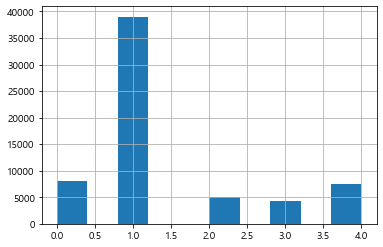

In [37]:
hit_log['이동거리_가중치'].hist()

#### 국가대표 차출 여부(아시안게임, 올림픽)

2018 아시안게임 명단(24) - 2018-08-18 ~ 09-02
* 투수(11) : 양현종, 임기영(이상 KIA), 박치국, 이용찬, 함덕주(이상 두산), 박종훈(SK), 임찬규(이상 LG), 정우람(한화), 최충연(삼성), 최원태, 장필준
* 포수(2) : 양의지(두산), 이재원(SK)
* 내야수(6) : 안치홍(KIA), 박민우(NC), 오지환(LG), 김하성, 박병호(이상 넥센), 황재균(KT)
* 외야수(5) : 김재환(두산), 손아섭(롯데), 김현수(LG), 박해민(삼성), 이정후(키움)

2020 도쿄올림픽 명단(24) - 2021-07-21 ~ 08-08
* 투수(11) : 최원준(두산), 고영표(kt), 고우석, 차우찬(이상 LG), 조상우(키움), 박세웅, 김진욱(이상 롯데), 오승환, 원태인(이상 삼성), 김민우(한화), 이의리(KIA)
* 포수(2) : 양의지(NC), 강민호(삼성)
* 내야수(7) : 강백호, 황재균(이상 kt), 오재일(삼성), 최주환(SSG), 허경민(두산), 오지환(LG), 김혜성(키움)
* 외야수(4) : 박건우(두산), 김현수(LG), 이정후(키움), 박해민(삼성)

In [38]:
# 대회 참여한 애들 참여 후 성적 확인하기

In [39]:
lst_18 = ['양의지', '이재원', '안치홍', '박민우', '오지환', '김하성', '박병호', '황재균', '김재환', '손아섭', '김현수', '박해민', '이정후']
lst_20 = ['양의지', '강민호', '강백호', '황재균', '오재일', '최주환', '허경민', '오지환', '김혜성', '박건우', '김현수', '이정후', '박해민']

In [40]:
hts['18_아시안게임'] = 0
hts.loc[(hts['선수명'].isin(lst_18)) & (hts['연도']==2018) & (hts['날짜']>="2018-09-02"), '18_아시안게임'] = 1

In [41]:
hts['18_아시안게임'].value_counts()

0    119815
1       930
Name: 18_아시안게임, dtype: int64

In [42]:
hit_log['18_아시안게임'] = 0
hit_log.loc[(hit_log['선수명'].isin(lst_18)) & (hit_log['연도']==2018) & (hit_log['날짜']>="2018-09-02"), '18_아시안게임'] = 1

In [43]:
hit_log['18_아시안게임'].value_counts()

0    63368
1      380
Name: 18_아시안게임, dtype: int64

In [44]:
a = hit_log.query('선수명 in @lst_18 and 연도==2018').groupby(['선수코드', '18_아시안게임'])['일타율'].mean().unstack().fillna(0)

# 76290 김현수는 아시안게임 이후 부상
a = a.query('선수코드 != 76290')
a[1]-a[0]

선수코드
62415.0    0.160735
62907.0    0.118659
64300.0   -0.073480
67341.0   -0.093524
75125.0   -0.042619
76232.0   -0.098700
76313.0    0.083590
76812.0   -0.070578
77532.0   -0.117581
78224.0    0.026697
79109.0    0.028407
79608.0   -0.108978
dtype: float64

In [45]:
np.mean(a[1]-a[0])

-0.015614320726579861

<AxesSubplot:xlabel='선수코드'>

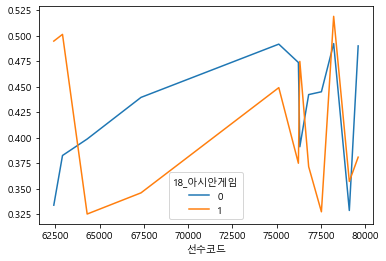

In [46]:
a.plot()

In [47]:
### 21년도 7월까지만 적용가능하므로 올림픽 차출 피쳐는 사용하지 못함 -> 아시안게임 차출도 못쓴다고 봄

#### 시간대

In [48]:
hts.columns

Index(['연도', '경기코드', '타구코드', '선수코드', '팀코드', '이닝', '타구속도', '발사각도', '타격결과',
       '상대투수투구구속', '해당구장', '상대팀코드', '날짜', '년', '월', '일', '시간', '요일', '선수명',
       '포지션', '나이', '연봉', '배럴', '타구출루', '18_아시안게임'],
      dtype='object')

In [49]:
hts.groupby(['선수코드', '시간'])['배럴'].mean().unstack().fillna(0)

시간,13,14,15,16,17,18,19,20,21,22,23
선수코드,,,,,,,,,,,
50054,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.00,0.0
50066,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.00,0.0
50150,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.00,0.0
50165,0.0,0.173913,0.050000,0.1,0.111111,0.106667,0.126316,0.100000,0.113208,0.25,0.0
50167,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.00,0.0
...,...,...,...,...,...,...,...,...,...,...,...
79530,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.00,0.0
79608,0.0,0.000000,0.000000,0.0,0.012500,0.011905,0.010101,0.008163,0.006250,0.00,0.0
79705,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.00,0.0


In [50]:
hts.groupby(['선수코드', '시간'])['타구출루'].mean().unstack().fillna(0)

시간,13,14,15,16,17,18,19,20,21,22,23
선수코드,,,,,,,,,,,
50054,0.0,1.000000,0.250000,0.000000,0.000000,0.000000,0.500000,0.363636,0.125000,0.000000,0.0
50066,0.0,0.000000,1.000000,0.333333,1.000000,1.000000,0.000000,0.250000,0.200000,0.000000,0.0
50150,0.0,0.000000,1.000000,0.000000,0.500000,0.000000,0.400000,0.444444,0.250000,0.000000,0.0
50165,0.0,0.304348,0.150000,0.550000,0.407407,0.306667,0.463158,0.422222,0.358491,0.500000,0.0
50167,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.0
...,...,...,...,...,...,...,...,...,...,...,...
79530,0.0,0.000000,0.000000,0.000000,0.000000,0.285714,0.333333,0.125000,1.000000,0.000000,0.0
79608,0.0,0.395349,0.340000,0.414634,0.400000,0.325397,0.360269,0.346939,0.456250,0.500000,0.8
79705,0.0,0.375000,0.500000,0.250000,0.166667,0.437500,0.280000,0.400000,0.363636,0.166667,0.0


#### 연속 경기 출장 횟수

In [51]:
# 어케하누,,,

## 모델링 데이터 만들기 - 라운드 기준

In [52]:
ga = hts.groupby('해당구장')['경기코드'].nunique().reset_index()
ga.columns = ['해당구장', '경기수']
ga = pd.merge(hts[hts.타격결과=='홈런'].groupby('해당구장')['타격결과'].count().reset_index().sort_values(by='타격결과', ascending=False), ga, 
              how='left', on='해당구장')
ga.columns = ['해당구장', '홈런수', '경기수']
ga['한경기홈런비율'] = (ga['홈런수'] / ga['경기수'])
ga = ga.sort_values(by='한경기홈런비율', ascending=False)
ga

,해당구장,홈런수,경기수,한경기홈런비율
9,마산,185,72,2.569444
1,문학,648,257,2.521401
2,대구,588,246,2.390244
7,창원,413,178,2.320225
3,사직,498,237,2.101266
4,수원,478,255,1.874510
5,대전,440,239,1.841004
6,광주,427,253,1.687747
8,고척,376,256,1.468750
0,잠실,679,508,1.336614


In [53]:
ga[['좌우','중간','좌우_중간','펜스']] = [0,0,0,0]
ga.loc[ga.해당구장=='마산',['좌우','중간','좌우_중간','펜스']] = [97,116,110,3.8]
ga.loc[ga.해당구장=='창원',['좌우','중간','좌우_중간','펜스']] = [101,122,123,3.3]
ga.loc[ga.해당구장=='문학',['좌우','중간','좌우_중간','펜스']] = [95,120,115,2.8]
ga.loc[ga.해당구장=='잠실',['좌우','중간','좌우_중간','펜스']] = [100,125,120,2.6]
ga.loc[ga.해당구장=='대구',['좌우','중간','좌우_중간','펜스']] = [99.5,122.5,107,3.6]
ga.loc[ga.해당구장=='사직',['좌우','중간','좌우_중간','펜스']] = [95,118,113,4.8]
ga.loc[ga.해당구장=='수원',['좌우','중간','좌우_중간','펜스']] = [98,120,115,4.0]
ga.loc[ga.해당구장=='대전',['좌우','중간','좌우_중간','펜스']] = [100,122,112,4.0]
ga.loc[ga.해당구장=='광주',['좌우','중간','좌우_중간','펜스']] = [99,121,116,2.6]
ga.loc[ga.해당구장=='고척',['좌우','중간','좌우_중간','펜스']] = [99,122,115.6,4]

In [54]:
ga['팀코드'] = ['NC','SK','SS','NC','LT','KT','HH','HT','WO','OB']
ga = ga.reset_index(drop=True)
ga

,해당구장,홈런수,경기수,한경기홈런비율,좌우,중간,좌우_중간,펜스,팀코드
0,마산,185,72,2.569444,97.0,116.0,110.0,3.8,NC
1,문학,648,257,2.521401,95.0,120.0,115.0,2.8,SK
2,대구,588,246,2.390244,99.5,122.5,107.0,3.6,SS
3,창원,413,178,2.320225,101.0,122.0,123.0,3.3,NC
4,사직,498,237,2.101266,95.0,118.0,113.0,4.8,LT
5,수원,478,255,1.874510,98.0,120.0,115.0,4.0,KT
6,대전,440,239,1.841004,100.0,122.0,112.0,4.0,HH
7,광주,427,253,1.687747,99.0,121.0,116.0,2.6,HT
8,고척,376,256,1.468750,99.0,122.0,115.6,4.0,WO
9,잠실,679,508,1.336614,100.0,125.0,120.0,2.6,OB


In [66]:
ga1 = hit_train.groupby('해당구장')['날짜'].nunique().reset_index()
ga1.columns = ['해당구장', '경기수']
ga1 = pd.merge(hit_train[hit_train.홈런 > 0].groupby('해당구장')['홈런'].sum().reset_index().sort_values(by='홈런', ascending=False),
               ga1, how='left', on='해당구장')
ga1.columns = ['해당구장','홈런수','경기수']
ga1['한경기홈런비율'] = (ga1['홈런수'] / ga1['경기수'])
ga1 = ga1.sort_values(by='한경기홈런비율', ascending=False)
ga1

,해당구장,홈런수,경기수,한경기홈런비율
9,마산,185,72,2.569444
2,대구,587,243,2.415638
1,문학,599,252,2.376984
7,창원,408,177,2.305085
3,사직,496,232,2.137931
4,수원,471,250,1.884000
5,대전,436,237,1.839662
6,광주,422,249,1.694779
8,고척,372,256,1.453125
0,잠실,678,502,1.350598


In [67]:
ga1[['좌우','중간','좌우_중간','펜스']] =[0,0,0,0]
ga1.loc[ga1.해당구장=='마산',['좌우','중간','좌우_중간','펜스']] = [97,116,110,3.8]
ga1.loc[ga1.해당구장=='창원',['좌우','중간','좌우_중간','펜스']] = [101,122,123,3.3]
ga1.loc[ga1.해당구장=='문학',['좌우','중간','좌우_중간','펜스']] = [95,120,115,2.8]
ga1.loc[ga1.해당구장=='잠실',['좌우','중간','좌우_중간','펜스']] = [100,125,120,2.6]
ga1.loc[ga1.해당구장=='대구',['좌우','중간','좌우_중간','펜스']] = [99.5,122.5,107,3.6]
ga1.loc[ga1.해당구장=='사직',['좌우','중간','좌우_중간','펜스']] = [95,118,113,4.8]
ga1.loc[ga1.해당구장=='수원',['좌우','중간','좌우_중간','펜스']] = [98,120,115,4.0]
ga1.loc[ga1.해당구장=='대전',['좌우','중간','좌우_중간','펜스']] = [100,122,112,4.0]
ga1.loc[ga1.해당구장=='광주',['좌우','중간','좌우_중간','펜스']] = [99,121,116,2.6]
ga1.loc[ga1.해당구장=='고척',['좌우','중간','좌우_중간','펜스']] = [99,122,115.6,4]

In [68]:
ga1['팀코드'] = ['NC','SK','SS','NC','LT','KT','HH','HT','WO','OB']
ga1 = ga1.reset_index(drop=True)
ga1

,해당구장,홈런수,경기수,한경기홈런비율,좌우,중간,좌우_중간,펜스,팀코드
0,마산,185,72,2.569444,97.0,116.0,110.0,3.8,NC
1,대구,587,243,2.415638,99.5,122.5,107.0,3.6,SK
2,문학,599,252,2.376984,95.0,120.0,115.0,2.8,SS
3,창원,408,177,2.305085,101.0,122.0,123.0,3.3,NC
4,사직,496,232,2.137931,95.0,118.0,113.0,4.8,LT
5,수원,471,250,1.884000,98.0,120.0,115.0,4.0,KT
6,대전,436,237,1.839662,100.0,122.0,112.0,4.0,HH
7,광주,422,249,1.694779,99.0,121.0,116.0,2.6,HT
8,고척,372,256,1.453125,99.0,122.0,115.6,4.0,WO
9,잠실,678,502,1.350598,100.0,125.0,120.0,2.6,OB


In [55]:
a = hts.groupby(['년','월','일','선수코드'])['팀코드','상대팀코드','해당구장','요일'].first().reset_index()
a

,년,월,일,선수코드,팀코드,상대팀코드,해당구장,요일
0,2018,3,24,61102,LG,NC,마산,5
1,2018,3,24,61353,WO,HH,고척,5
2,2018,3,24,61404,SS,OB,잠실,5
3,2018,3,24,61869,SK,LT,문학,5
4,2018,3,24,62404,SS,OB,잠실,5
...,...,...,...,...,...,...,...,...
49665,2021,7,11,78513,LT,SS,대구,6
49666,2021,7,11,78548,KT,HT,광주,6
49667,2021,7,11,78603,HT,KT,광주,6
49668,2021,7,11,78643,HH,SK,문학,6


In [56]:
train = pd.merge(a, hit[['연도', '선수코드', '선수명', '나이', '연봉']], how='left', 
                 left_on=['선수코드','년'], right_on=['선수코드','연도']).drop('연도',axis=1)
train = train.drop(train[train.나이.isna()].index, axis=0).reset_index().drop('index',axis=1)
train

,년,월,일,선수코드,팀코드,상대팀코드,해당구장,요일,선수명,나이,연봉
0,2018,3,24,61102,LG,NC,마산,5,유강남,25,18500
1,2018,3,24,61353,WO,HH,고척,5,고종욱,29,11000
2,2018,3,24,61404,SS,OB,잠실,5,김헌곤,29,8500
3,2018,3,24,61869,SK,LT,문학,5,정진기,25,6200
4,2018,3,24,62404,SS,OB,잠실,5,구자욱,25,25000
...,...,...,...,...,...,...,...,...,...,...,...
49665,2021,7,11,78513,LT,SS,대구,6,전준우,35,50000
49666,2021,7,11,78548,KT,HT,광주,6,장성우,31,21000
49667,2021,7,11,78603,HT,KT,광주,6,김선빈,31,45000
49668,2021,7,11,78643,HH,SK,문학,6,백용환,32,4000


In [57]:
hit_train = pd.merge(hit_log, train[['년', '월', '일', '상대팀코드', '해당구장', '선수명']], 
                   how='left', left_on=['년', '월', '일', '선수명', '상대팀코드'], right_on=['년', '월', '일', '선수명', '상대팀코드'])

In [74]:
hit_train.shape

(63748, 53)

### 라운드 넣어주기

In [70]:
a = list(range(1,145))

In [71]:
hit_train.팀코드.unique()

array(['HH', 'SS', 'KT', 'LT', 'SK', 'NC', 'LG', 'HT', 'OB', 'WO'],
      dtype=object)

In [73]:
# 2018년
HH_18=hit_train[(hit_train.팀코드=='HH')&(hit_train.년==2018)].groupby(['날짜','결과']).first().reset_index();HH_18['라운드']=a
SS_18=hit_train[(hit_train.팀코드=='SS')&(hit_train.년==2018)].groupby(['날짜','결과']).first().reset_index();SS_18['라운드']=a
KT_18=hit_train[(hit_train.팀코드=='KT')&(hit_train.년==2018)].groupby(['날짜','결과']).first().reset_index();KT_18['라운드']=a
LT_18=hit_train[(hit_train.팀코드=='LT')&(hit_train.년==2018)].groupby(['날짜','결과']).first().reset_index();LT_18['라운드']=a
SK_18=hit_train[(hit_train.팀코드=='SK')&(hit_train.년==2018)].groupby(['날짜','결과']).first().reset_index();SK_18['라운드']=a
NC_18=hit_train[(hit_train.팀코드=='NC')&(hit_train.년==2018)].groupby(['날짜','결과']).first().reset_index();NC_18['라운드']=a
HT_18=hit_train[(hit_train.팀코드=='HT')&(hit_train.년==2018)].groupby(['날짜','결과']).first().reset_index();HT_18['라운드']=a
OB_18=hit_train[(hit_train.팀코드=='OB')&(hit_train.년==2018)].groupby(['날짜','결과']).first().reset_index();OB_18['라운드']=a
WO_18=hit_train[(hit_train.팀코드=='WO')&(hit_train.년==2018)].groupby(['날짜','결과']).first().reset_index();WO_18['라운드']=a
LG_18=hit_train[(hit_train.팀코드=='LG')&(hit_train.년==2018)].groupby(['날짜','결과']).first().reset_index();LG_18['라운드']=a

ValueError: Length of values (144) does not match length of index (148)

In [ ]:
# 2019년
HH_19=hit_train[(hit_train.팀코드=='HH')&(hit_train.년==2019)].groupby(['날짜','경기결과']).first().reset_index();HH_19['라운드']=a
SS_19=hit_train[(hit_train.팀코드=='SS')&(hit_train.년==2019)].groupby(['날짜','경기결과']).first().reset_index();SS_19['라운드']=a
KT_19=hit_train[(hit_train.팀코드=='KT')&(hit_train.년==2019)].groupby(['날짜','경기결과']).first().reset_index();KT_19['라운드']=a
LT_19=hit_train[(hit_train.팀코드=='LT')&(hit_train.년==2019)].groupby(['날짜','경기결과']).first().reset_index();LT_19['라운드']=a
SK_19=hit_train[(hit_train.팀코드=='SK')&(hit_train.년==2019)].groupby(['날짜','경기결과']).first().reset_index();SK_19['라운드']=a
NC_19=hit_train[(hit_train.팀코드=='NC')&(hit_train.년==2019)].groupby(['날짜','경기결과']).first().reset_index();NC_19['라운드']=a
HT_19=hit_train[(hit_train.팀코드=='HT')&(hit_train.년==2019)].groupby(['날짜','경기결과']).first().reset_index();HT_19['라운드']=a
OB_19=hit_train[(hit_train.팀코드=='OB')&(hit_train.년==2019)].groupby(['날짜','경기결과']).first().reset_index();OB_19['라운드']=a
WO_19=hit_train[(hit_train.팀코드=='WO')&(hit_train.년==2019)].groupby(['날짜','경기결과']).first().reset_index();WO_19['라운드']=a
LG_19=hit_train[(hit_train.팀코드=='LG')&(hit_train.년==2019)].groupby(['날짜','경기결과']).first().reset_index();LG_19['라운드']=a

In [ ]:
# 2020년
HH_20=hit_train[(hit_train.팀코드=='HH')&(hit_train.년==2020)].groupby(['날짜','경기결과']).first().reset_index();HH_20['라운드']=a
SS_20=hit_train[(hit_train.팀코드=='SS')&(hit_train.년==2020)].groupby(['날짜','경기결과']).first().reset_index();SS_20['라운드']=a
KT_20=hit_train[(hit_train.팀코드=='KT')&(hit_train.년==2020)].groupby(['날짜','경기결과']).first().reset_index();KT_20['라운드']=a
LT_20=hit_train[(hit_train.팀코드=='LT')&(hit_train.년==2020)].groupby(['날짜','경기결과']).first().reset_index();LT_20['라운드']=a
SK_20=hit_train[(hit_train.팀코드=='SK')&(hit_train.년==2020)].groupby(['날짜','경기결과']).first().reset_index();SK_20['라운드']=a
NC_20=hit_train[(hit_train.팀코드=='NC')&(hit_train.년==2020)].groupby(['날짜','경기결과']).first().reset_index();NC_20['라운드']=a
HT_20=hit_train[(hit_train.팀코드=='HT')&(hit_train.년==2020)].groupby(['날짜','경기결과']).first().reset_index();HT_20['라운드']=a
OB_20=hit_train[(hit_train.팀코드=='OB')&(hit_train.년==2020)].groupby(['날짜','경기결과']).first().reset_index();OB_20['라운드']=a
WO_20=hit_train[(hit_train.팀코드=='WO')&(hit_train.년==2020)].groupby(['날짜','경기결과']).first().reset_index();WO_20['라운드']=a
LG_20=hit_train[(hit_train.팀코드=='LG')&(hit_train.년==2020)].groupby(['날짜','경기결과']).first().reset_index();LG_20['라운드']=a

In [ ]:
# 2021년
HH_21=hit_train[(hit_train.팀코드=='HH')&(hit_train.년==2021)].groupby(['날짜','경기결과']).first().reset_index();HH_21['라운드']=list(range(1,80))
SS_21=hit_train[(hit_train.팀코드=='SS')&(hit_train.년==2021)].groupby(['날짜','경기결과']).first().reset_index();SS_21['라운드']=list(range(1,80))
KT_21=hit_train[(hit_train.팀코드=='KT')&(hit_train.년==2021)].groupby(['날짜','경기결과']).first().reset_index();KT_21['라운드']=list(range(1,76))
LT_21=hit_train[(hit_train.팀코드=='LT')&(hit_train.년==2021)].groupby(['날짜','경기결과']).first().reset_index();LT_21['라운드']=list(range(1,78))
SK_21=hit_train[(hit_train.팀코드=='SK')&(hit_train.년==2021)].groupby(['날짜','경기결과']).first().reset_index();SK_21['라운드']=list(range(1,79))
NC_21=hit_train[(hit_train.팀코드=='NC')&(hit_train.년==2021)].groupby(['날짜','경기결과']).first().reset_index();NC_21['라운드']=list(range(1,75))
HT_21=hit_train[(hit_train.팀코드=='HT')&(hit_train.년==2021)].groupby(['날짜','경기결과']).first().reset_index();HT_21['라운드']=list(range(1,75))
OB_21=hit_train[(hit_train.팀코드=='OB')&(hit_train.년==2021)].groupby(['날짜','경기결과']).first().reset_index();OB_21['라운드']=list(range(1,75))
WO_21=hit_train[(hit_train.팀코드=='WO')&(hit_train.년==2021)].groupby(['날짜','경기결과']).first().reset_index();WO_21['라운드']=list(range(1,80))
LG_21=hit_train[(hit_train.팀코드=='LG')&(hit_train.년==2021)].groupby(['날짜','경기결과']).first().reset_index();LG_21['라운드']=list(range(1,76))

In [ ]:
round_all = pd.concat([HH_18, SS_18, KT_18, LT_18, SK_18, NC_18, HT_18, OB_18, WO_18, LG_18,
                       HH_19, SS_19, KT_19, LT_19, SK_19, NC_19, HT_19, OB_19, WO_19, LG_19,
                       HH_20, SS_20, KT_20, LT_20, SK_20, NC_20, HT_20, OB_20, WO_20, LG_20,
                       HH_21, SS_21, KT_21, LT_21, SK_21, NC_21, HT_21, OB_21, WO_21, LG_21])

In [ ]:
data = pd.merge(hit_train,round_all[['날짜','경기결과','상대팀코드','팀코드','라운드']], how='left', 
                on=['날짜','경기결과','상대팀코드','팀코드'])

In [ ]:
data = pd.merge(data, ga1[['해당구장','한경기홈런비율','좌우','중간','좌우_중간','펜스']], how='left', on='해당구장')

In [69]:
data

{'연도': 2020,
 '선수코드': 50802,
 '선수명': '화이트',
 '팀코드': 'SK',
 '포지션': '내',
 '나이': 31,
 '연봉': 16000}